In [ ]:
# default_exp icevision_example

# Exploring Object Detection using Icevision

I was unable to make much progress using Pytorch Lightning & Torch Vision on a tiny subset of Coco Dataset. 
I got a model to run for hundreds of epochs, with seemingly improving training loss, but prediction is still garbage.

So I decided to get an end to end object detection working example before diving back in. This time I chose https://github.com/airctic/icevision

Following their [first example](https://airctic.com/examples/training/) for pytorch lightning...

In [ ]:
#export 
import icevision
from icevision.all import *
import icedata
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [ ]:
icevision.__version__

'0.1.3.post2'

## Load pet dataset...

In [ ]:
path = icedata.pets.load()
path

/home/brian/miniconda3/lib/python3.8/site-packages/icedata/datasets/pets/data.py:75: UserWarning: load will be deprecated in 0.1.0, please use load_data instead
  warnings.warn("load will be deprecated in 0.1.0, please use load_data instead")


Path('/home/brian/.icevision/data/pets')

## Get the class_map, a utility that maps from number IDs to classs names

In [ ]:
class_map = icedata.pets.class_map()
class_map

<ClassMap: {'background': 0, 'Abyssinian': 1, 'Bengal': 2, 'Birman': 3, 'Bombay': 4, 'British_Shorthair': 5, 'Egyptian_Mau': 6, 'Maine_Coon': 7, 'Persian': 8, 'Ragdoll': 9, 'Russian_Blue': 10, 'Siamese': 11, 'Sphynx': 12, 'american_bulldog': 13, 'american_pit_bull_terrier': 14, 'basset_hound': 15, 'beagle': 16, 'boxer': 17, 'chihuahua': 18, 'english_cocker_spaniel': 19, 'english_setter': 20, 'german_shorthaired': 21, 'great_pyrenees': 22, 'havanese': 23, 'japanese_chin': 24, 'keeshond': 25, 'leonberger': 26, 'miniature_pinscher': 27, 'newfoundland': 28, 'pomeranian': 29, 'pug': 30, 'saint_bernard': 31, 'samoyed': 32, 'scottish_terrier': 33, 'shiba_inu': 34, 'staffordshire_bull_terrier': 35, 'wheaten_terrier': 36, 'yorkshire_terrier': 37}>

## PETS parser: provided out-of-the-box

In [ ]:
parser = icedata.pets.parser(data_dir=path, class_map=class_map)
train_records, valid_records = parser.parse()

## shows images with corresponding labels and boxes

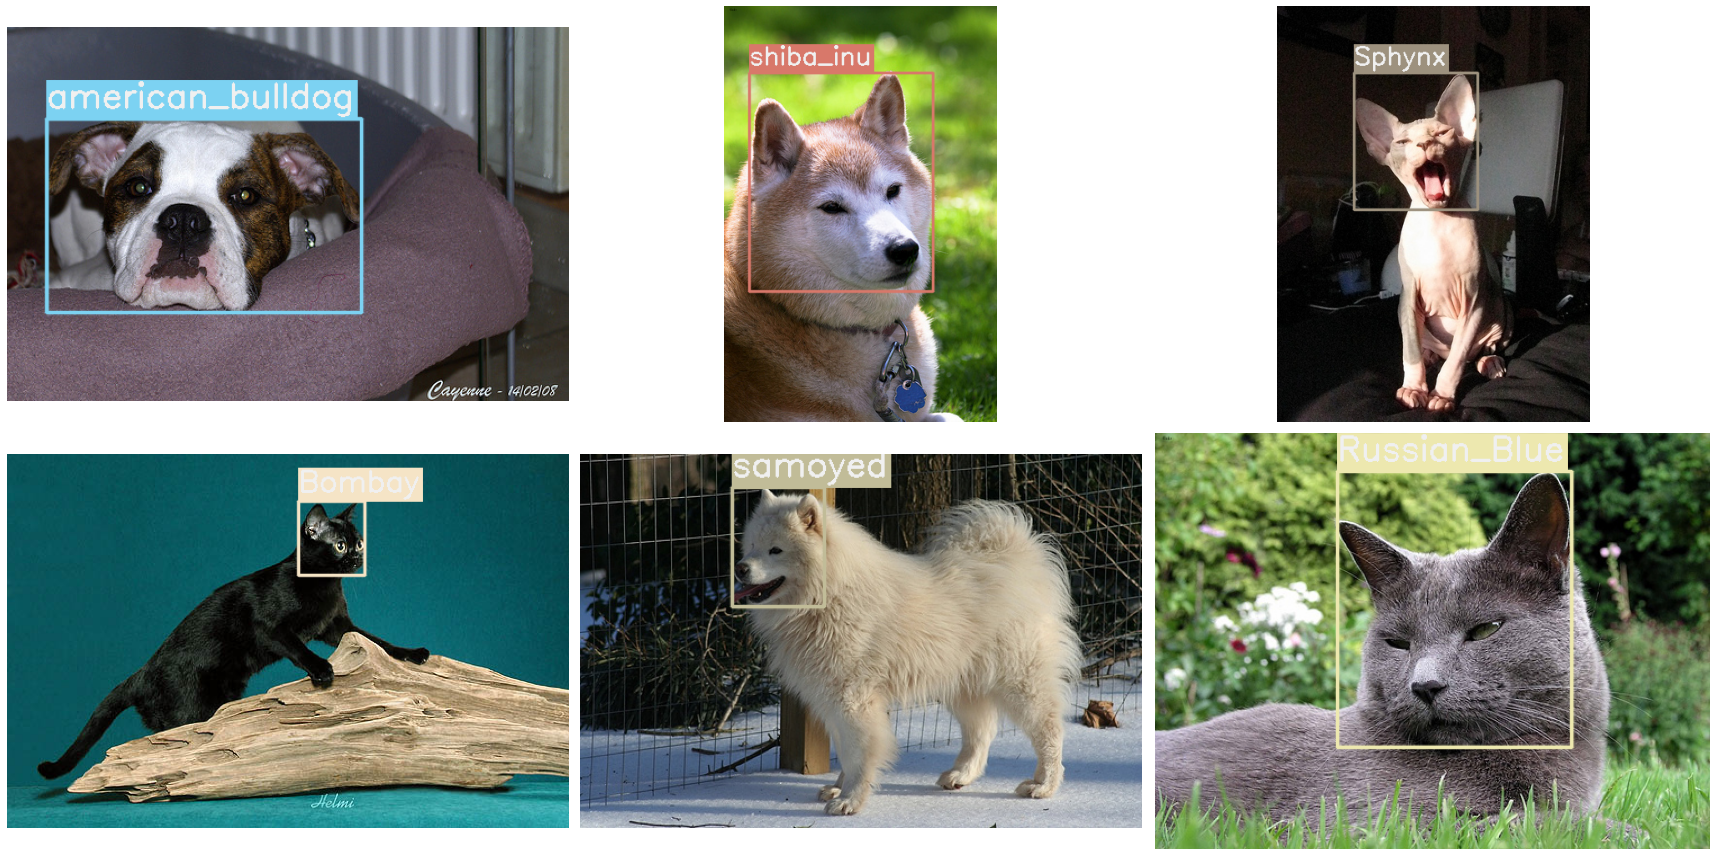

In [ ]:
show_records(train_records[:6], ncols=3, class_map=class_map, show=True)

## Define transforms - using Albumentations transforms out of the box

In [ ]:
size=256
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=size, presize=512), tfms.A.Normalize()]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

## Create both training and validation datasets

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

## Create both training and validation dataloaders

In [ ]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=14, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=14, num_workers=4, shuffle=False)

## Create model

In [ ]:
model = faster_rcnn.model(num_classes=len(class_map))

## Define metrics

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Train using pytorch-lightning

In [ ]:
class LightModel(faster_rcnn.lightning.ModelAdapter):
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

light_model = LightModel(model, metrics=metrics)
chkpt_cb = ModelCheckpoint(
    filepath='model/ice-pets.ckpt',
    save_last=True,
    mode='auto'
)

trainer = pl.Trainer(max_epochs=1, gpus=1, checkpoint_callback=chkpt_cb, accumulate_grad_batches=3)
trainer.fit(light_model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


1

## Inference

In [ ]:
img = valid_ds[100]
ti = torch.tensor(img['img'])
tip=ti.permute(2,0,1)
ti.shape, tip.shape

(torch.Size([256, 256, 3]), torch.Size([3, 256, 256]))

In [ ]:
light_model.freeze()
pred = light_model([tip])
pred

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

## Interpret the Prediction

## Saving Model Explicitly

Saving it explicitly after 10 epochs.

In [ ]:
model_save_path = "model/ice-pets.saved"
# trainer.save_checkpoint(model_save_path)
torch.save(light_model.model.state_dict(), model_save_path)

In [ ]:
# pretrained_model = light_model.load_from_checkpoint(model_save_path)

pretrained_model = LightModel(model, metrics=metrics)
pretrained_model.model.load_state_dict(torch.load(model_save_path))
pretrained_model.freeze()

In [ ]:
pred = pretrained_model([tip])
pred